In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Download Source & Target Images From Google Drive

#### Helper Functions

In [ ]:
def copyFromGoogleDriveAndUnzip(gDrivePath):
    zip_filename = gDrivePath.split('/')[-1]
    if not os.path.exists(zip_filename):
      shutil.copyfile(gDrivePath, zip_filename)
      !unzip -q $zip_filename

#### Controls

In [ ]:
gdrive_source_image_path = '/content/gdrive/My Drive/Covid-19 Research/Covid-19 Prognosis From CXR/Data/RibSuppression/Kaggle-source.zip'
gdrive_target_image_path = '/content/gdrive/My Drive/Covid-19 Research/Covid-19 Prognosis From CXR/Data/RibSuppression/Kaggle-target.zip'

In [ ]:
batch_size = 16

#### Download Files From Google Drive

In [ ]:
%%time
copyFromGoogleDriveAndUnzip(gdrive_source_image_path)
copyFromGoogleDriveAndUnzip(gdrive_target_image_path)

CPU times: user 661 ms, sys: 4.13 s, total: 4.79 s
Wall time: 41.3 s


In [ ]:
source_files = os.listdir('source')
target_files = os.listdir('target')
print('Source files found:', len(source_files))
print('Target files found:', len(target_files))
if set(source_files) == set(target_files):
  print('Directories source & target have same filenames')
else:
  print('Directories source & target have different filenames')

Source files found: 4080
Target files found: 4080
Directories source & target have same filenames


### Data Generators

In [ ]:
def read_image_and_resize(image_path, image_shape=[256, 256]):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, image_shape, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  
    # Convert image to float32 tensors
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image

def load_source_and_target_image(source_filepath, target_filepath, image_shape=[256, 256]):
    source_image = read_image_and_resize(source_filepath, image_shape=image_shape)
    target_image = read_image_and_resize(target_filepath, image_shape=image_shape)

    return source_image, target_image

In [ ]:
image_filenames = os.listdir('source') # source & target have same filenames
train_val_filenames, test_filenames = train_test_split(image_filenames, test_size=0.1, random_state=2002)
train_filenames, val_filenames = train_test_split(train_val_filenames, test_size=0.2, random_state=2002)
print('Train image count:', len(train_filenames))
print('Validation image count:', len(val_filenames))
print('Test image count:', len(test_filenames))

Train image count: 2937
Validation image count: 735
Test image count: 408


In [ ]:
def createDataset(filenames, batch_size=16):
    source_file_paths = [os.path.join('source', x) for x in filenames]
    target_file_paths = [os.path.join('target', x) for x in filenames]
    dataset = tf.data.Dataset.from_tensor_slices((source_file_paths, target_file_paths))
    dataset = dataset.shuffle(len(source_file_paths))
    dataset = dataset.map(load_source_and_target_image)
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)  
    return dataset

In [ ]:
train_dataset = createDataset(train_filenames, batch_size)
val_dataset = createDataset(val_filenames, batch_size)
test_dataset = createDataset(test_filenames, batch_size)

#### Display Random Samples Using Datasets

In [ ]:
def displayRandomImages(ds):
  for item in ds:
    random_index = random.randint(0, (batch_size-1))
    source_im = item[0][random_index]
    target_im = item[1][random_index]
    # print(tf.reduce_min(source_im).numpy(), tf.reduce_max(source_im).numpy())
    break
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  ax[0].imshow(source_im[:,:,0], cmap='gray')
  ax[1].imshow(target_im[:,:,0], cmap='gray')

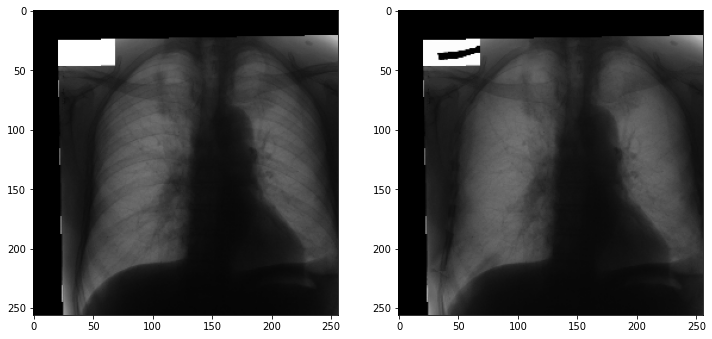

In [ ]:
displayRandomImages(train_dataset)

### Model

In [ ]:
def loss_mix_multi_084(y_true, y_pred):  
    alpha=0.84
    # MSE
    mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_true), 1) 
       
    # MS SSIM
    ssim = tf.reduce_mean(1 - tf.image.ssim_multiscale(y_true, y_pred, 1))

    # Mixed cost
    loss = alpha * ssim + (1 - alpha) * mse

    return loss

def resnet_bs(num_filters=64, num_res_blocks=16, res_block_scaling=None):
    x_in = tf.keras.layers.Input(shape=(256,256,1))
    x = b = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(x_in)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(b)
    x = tf.keras.layers.Add()([x, b])
    x = tf.keras.layers.Conv2D(1, (3, 3), padding='same')(x)
    return tf.keras.Model(x_in, x, name="ResNet-BS")

def res_block(x_in, filters, scaling):
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x_in)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    if scaling:
        x = tf.keras.layers.Lambda(lambda t: t * scaling)(x)
    x = tf.keras.layers.Add()([x_in, x])
    return x

resnet_bs_model = resnet_bs(num_filters=64, num_res_blocks=16, res_block_scaling=0.1)
resnet_bs_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss_mix_multi_084) 


In [ ]:
EPOCHS = 20

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=0.00001)
callbacks_list = [earlyStopping, reduce_lr]

history = resnet_bs_model.fit(train_dataset,
                              batch_size=batch_size,
                              epochs = EPOCHS,
                              verbose = 1,
                              callbacks=callbacks_list,
                              shuffle=True,
                              validation_data = val_dataset)

Epoch 1/20
184/184 [==============================] - 229s 1s/step - loss: 0.0206 - val_loss: 0.0130 - lr: 0.0010
Epoch 2/20
184/184 [==============================] - 205s 1s/step - loss: 0.0126 - val_loss: 0.0122 - lr: 0.0010
Epoch 3/20
184/184 [==============================] - 205s 1s/step - loss: 0.0120 - val_loss: 0.0118 - lr: 0.0010
Epoch 4/20
184/184 [==============================] - 205s 1s/step - loss: 0.0115 - val_loss: 0.0113 - lr: 0.0010
Epoch 5/20
184/184 [==============================] - 205s 1s/step - loss: 0.0111 - val_loss: 0.0110 - lr: 0.0010
Epoch 6/20
184/184 [==============================] - 205s 1s/step - loss: 0.0107 - val_loss: 0.0106 - lr: 0.0010
Epoch 7/20
184/184 [==============================] - 205s 1s/step - loss: 0.0104 - val_loss: 0.0104 - lr: 0.0010
Epoch 8/20
184/184 [==============================] - 205s 1s/step - loss: 0.0102 - val_loss: 0.0102 - lr: 0.0010
Epoch 9/20
184/184 [==============================] - 205s 1s/step - loss: 0.0099 - val_

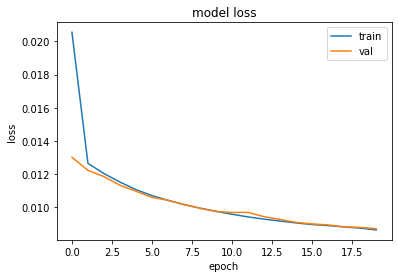

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Save Model

In [ ]:
model_save_path = 'Rib_Suppression_Model_ResNet.h5' 
resnet_bs_model.save(model_save_path, include_optimizer=False)  
print(model_save_path)

Rib_Suppression_Model_ResNet.h5


### Load Model From Disk & Use It To Generate Rib Suppressed CXR

In [ ]:
def displayRandomImagesAndPrediction(ds, predictions):
    for item in ds:
        random_index = random.randint(0, (batch_size-1))
        source_im = item[0][random_index]
        target_im = item[1][random_index]
        prediction_im = predictions[random_index, :, :, 0]
        break
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))
    ax[0].imshow(source_im[:,:,0], cmap='gray')
    ax[0].set_title('Original')
    ax[1].imshow(target_im[:,:,0], cmap='gray')
    ax[1].set_title('Target')
    ax[2].imshow(prediction_im, cmap='gray')
    ax[2].set_title('Model Output')
    ax[3].imshow(target_im[:,:,0] - prediction_im, cmap='gray')
    ax[3].set_title('Diff')  

In [ ]:
model_from_disk = tf.keras.models.load_model('Rib_Suppression_Model_ResNet.h5', compile=False)
predictions = model_from_disk.predict(test_dataset)
print('Shape of prediction:', predictions.shape)

Shape of prediction: (408, 256, 256, 1)


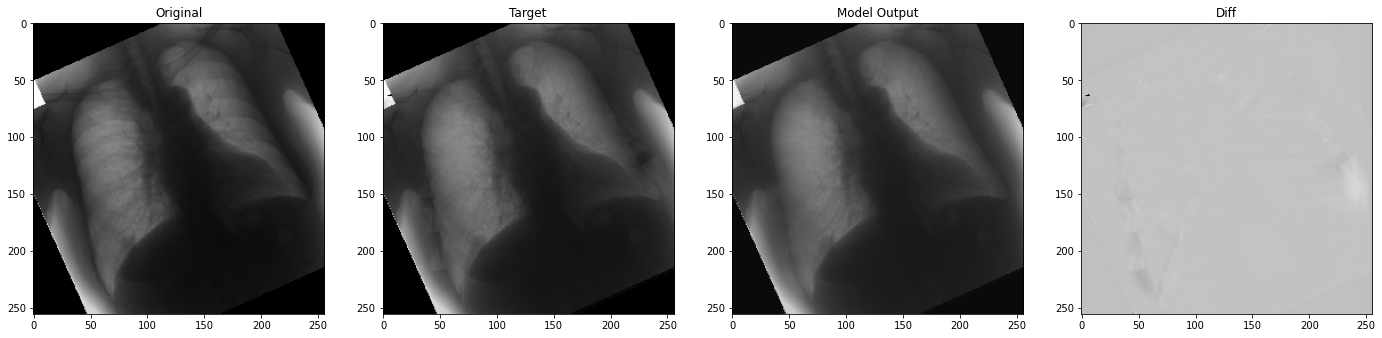

In [ ]:
displayRandomImagesAndPrediction(test_dataset, predictions)

### Try with Internet CXRs

In [ ]:
from PIL import Image
import requests

In [ ]:
def download_image_and_resize(url, image_shape=[256, 256]):
    image = Image.open(requests.get(url, stream=True).raw)
    image = np.array(image)
    h, w = image.shape
    image = np.reshape(image, [h,w,1])
    image = tf.image.resize(image, image_shape, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)  
    # Convert image to float32 tensors
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image

In [ ]:
cxr_url = 'http://www.meddean.luc.edu/lumen/meded/radio/curriculum/Pulmonary/image.jpg'

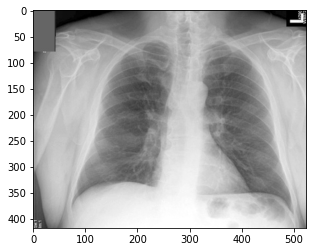

In [ ]:
im = Image.open(requests.get(cxr_url, stream=True).raw)
plt.imshow(im, cmap='gray');

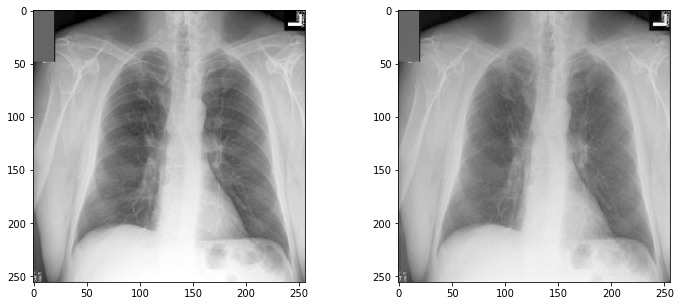

In [ ]:
im_resized = download_image_and_resize(cxr_url)
rib_suppressed_cxr = model_from_disk.predict(np.expand_dims(im_resized, axis=0))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(im_resized[:,:,0], cmap='gray');
ax[1].imshow(rib_suppressed_cxr[0,:,:,0], cmap='gray');